<a href="https://colab.research.google.com/github/mvoassis/CIC-DDoS2019-DeepLearning/blob/main/Bank_Policy_Scoring_Coal_Expansion_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPT Expansion score

Summarized Approach:

- Extract comments from the CPT dataset
  - Positive comments (1 per bank policy)
  - Negative comments (up to 3 per bank policy)
- Submit the entire bank policy to GPT4-turbo for scoring generation in two steps:
 1. Positive score
 2. Negative score(s)
- Finally, calculate the general score, subtracting the positive with the negative ones.

## Extracting positive and negative comments

In the Coal Policy Tracker (CPT) dataset, there is a 'Comment' section for each scored bank. It looks like:

```
Projects: Exclusion of thermal coal mines, coal plants including retrofits, and coal infrastructure projects (score 10).
Expansion: Exclusion of coal mine/plant/infrastructure developers (score 9), but financing to the parent company remains possible (penalty -2) and only applies to utilities and not to companies planning coal captive projects for specific industrial uses (penalty -1)
Relative: Exclusion of mining companies above 20% of revenues from coal (score 2), and groups not covered (penalty -2, but minimum score 1).
Absolute: Exclusion of mining companies above 10 Mt of annual thermal coal production (score 5), but financing to the parent company remains possible (penalty -2).
Phase-out: Phase-out of the coal mining and power sector in the EU/OECD by 2030 and worldwide by 2040 with mandatory requirement for coal companies to have an exit plan aligned and exclusion of some coal mine/plant/infrastructure developers (score 4) with the final exclusion threshold below 5% (bonus +1)
Source: Press release (May 2020); Coal Power Sector Policy (July 2020); Mining Sector Policy (July 2020, November 2023)
```

Thus, in this step, the objective is to extract all possible justificatives (positive and negative ones) regarding "Expansion", as well as their respective scores.

In this case, it would be:

```
positive:
*Exclusion of coal mine/plant/infrastructure developers (score 9)

negatives:
* but financing to the parent company remains possible (penalty -2)
* and only applies to utilities and not to companies planning coal captive projects for specific industrial uses (penalty -1)
```

With this approach, the gpt4-turbo can act as a text classifier, evaluating the bank policy as an input and using all the possible justifications to find which one better fits the bank's policy. But this would be the next step.

> First, lets extract and organize the information of scores and penalties:


In [ ]:
# importing libs

import pandas as pd
import re

In [ ]:
#importing the CPT dataset

cpt = pd.read_excel('CoalPolicyTracker.xlsx')
cpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 136 non-null    object 
 1   Type                    136 non-null    object 
 2   Financial institutions  136 non-null    object 
 3   Projects                136 non-null    int64  
 4   Expansion               136 non-null    int64  
 5   Relative threshold      136 non-null    int64  
 6   Absolute threshold      136 non-null    int64  
 7   Phase out               136 non-null    object 
 8   Projects.1              136 non-null    int64  
 9   Expansion.1             135 non-null    float64
 10  Comment                 136 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 11.8+ KB


In [ ]:
#taking a look at the 'Comment' column format

cpt.Comment.iloc[0]

'Global evaluation\nProjects: Exclusion of new thermal coal mines and new coal plants (score 8).\nExpansion: Exclusion of some thermal coal developers, with large uncertainty on the exact definition (score 3).\nRelative: Exclusion of mining companies above 25% of revenues from coal and power companies above 50% of coal capacity (score 4), but wrong metric used capacity instead of generation (penalty -1), and only for lending (penalty -1).\nAbsolute: No commitment regarding this criterion.\nPhase-out: No commitment regarding this criterion.\nSource: Metals and Minerals Requirements (June 2018) ; Power Generation Requirements (June 2018)\nhttps://assets.ctfassets.net/1u811bvgvthc/4DaQBrHmnwN6BZ0UZ2Mso0/000262cd80e628bb3d1f0be39f5a299b/Metals_and_Minerals_Sustainability_Req.pdf\nhttps://assets.ctfassets.net/1u811bvgvthc/1zral0VTxPPBhQkNkXmazH/82dfe5e85e74b33432a79b18d6809e18/Power_Generation_Sustainability_Requirements.pdf\n\nFocus on metallurgical coal\nProjects: No metallurgical coal co

In [ ]:
# Extracting only the "Expansion" section of the comment using regular expression

cpt['extracted_text'] = cpt['Comment'].str.extract(r'\nExpansion:(.*?)\nRelative:', flags=re.DOTALL)
cpt.extracted_text.iloc[0]

' Exclusion of some thermal coal developers, with large uncertainty on the exact definition (score 3).'

In [ ]:
# Taking a look at all unique justificatives

cpt.extracted_text.unique()

array([' Exclusion of some thermal coal developers, with large uncertainty on the exact definition (score 3).',
       ' No commitment regarding this criterion.',
       ' No thermal coal policy.',
       ' Exclusion, from 2023, of some coal mine/plant developers, with some exceptions and only for utilities (score 3).',
       ' Exclusion of coal mine/plant/infrastructure developers (score 9), but financing to the parent company remains possible (penalty -2) and only applies to utilities and not to companies planning coal captive projects for specific industrial uses (penalty -1)',
       ' Exclusion of all coal mine and coal plant developers since the end of 2021 (score 8), but only for utilities (penalty -1), the threshold for coal power developers is 300MW (penalty -1), and green bonds are not excluded (penalty -1).',
       ' Exclusion of coal plant developpers but only for new clients (score 1).',
       ' Exclusion of coal mine/plant/infrastructure developers but only for new cli

> Since scores and penalties are described on the same line, there are plenty of differenc combinations for it. Thus, we need to continue breaking it to achieve more general classes.

In [ ]:
# Using regular expressions to extract scores (positive scores) from penalties (negative scores) values.

cpt['score'] = cpt['extracted_text'].str.extract(r'score (\d+)', flags=re.IGNORECASE)
cpt['penalty'] = cpt['extracted_text'].str.extract(r'penalty (-?\d+)', flags=re.IGNORECASE)

In [ ]:
# Using regular expressions to extract positive (text_before_score) from negative (text_after_score) texts
cpt['text_before_score'] = cpt['extracted_text'].str.extract(r'^(.*\(score \d+\))', flags=re.DOTALL)
cpt['text_after_score'] = cpt['extracted_text'].str.extract(r'\(score \d+\). (.*)', flags=re.DOTALL)


In [ ]:
cpt.sample(5)

Country  Type  Financial institutions  Projects  Expansion  \
46    Canada  Bank              Desjardins        10          9   
10     China  Bank  Bank of Communications         0          0   
110   Russia  Bank                Sberbank         0          0   
59   Germany  Bank                  Helaba         8          0   
93   Finland  Bank                      OP         8          7   

     Relative threshold  Absolute threshold Phase out  Projects.1  \
46                   10                  10         5           0   
10                    0                   0         0           0   
110                   0                   0         0           0   
59                    1                   0         0           0   
93                    1                   0         0           0   

     Expansion.1                                            Comment  \
46           0.0  Global evaluation\nProjects: Full exclusion of...   
10           0.0  Global evaluation\nProjects: No thermal coal p...   
110          0.0  Global evaluation\nProjects: No thermal coal p...   
59           0.0  Global evaluation\nProjects: Exclusion of new ...   
93           0.0  Global evaluation\nProjects: Exclusion of new ...   

                                        extracted_text score penalty  \
46    Exclusion of coal mine/plant/infrastructure d...     9     NaN   
10                             No thermal coal policy.   NaN     NaN   
110                            No thermal coal policy.   NaN     NaN   
59             No commitment regarding this criterion.   NaN     NaN   
93    Exclusion of thermal coal mines and coal plan...     8      -1   

                                     text_before_score  \
46    Exclusion of coal mine/plant/infrastructure d...   
10                                                 NaN   
110                                                NaN   
59                                                 NaN   
93    Exclusion of thermal coal mines and coal plan...   

                       text_after_score  
46                                  NaN  
10                                  NaN  
110                                 NaN  
59                                  NaN  
93   but only for lending (penalty -1).

In [ ]:
# Taking a look at the unique "classes" for positive scores
cpt.text_before_score.unique()

array([' Exclusion of some thermal coal developers, with large uncertainty on the exact definition (score 3)',
       nan,
       ' Exclusion, from 2023, of some coal mine/plant developers, with some exceptions and only for utilities (score 3)',
       ' Exclusion of coal mine/plant/infrastructure developers (score 9)',
       ' Exclusion of all coal mine and coal plant developers since the end of 2021 (score 8)',
       ' Exclusion of coal plant developpers but only for new clients (score 1)',
       ' Exclusion of coal mine/plant/infrastructure developers but only for new clients (score 1)',
       ' Exclusion of coal plant/mine/infrastructure developers and companies buying coal assets (score 9)',
       ' Exclusion of all companies developing new coal mining and/or coal power projects (score 8)',
       ' Exclusion of mining and power companies increasing their coal capacity (score 3)',
       ' Exclusion of all coal power developers (score 7)',
       ' Exclusion of coal mine/plan

In [ ]:
# Taking a look at the unique "classes" for negative scores (penalties)

cpt.text_after_score.unique()

array([nan,
       'but financing to the parent company remains possible (penalty -2) and only applies to utilities and not to companies planning coal captive projects for specific industrial uses (penalty -1)',
       'but only for utilities (penalty -1), the threshold for coal power developers is 300MW (penalty -1), and green bonds are not excluded (penalty -1).',
       'but only for coal plant developers over 300 MW (penalty -1) and with some exceptions (penalty -2).',
       'but large exceptions (penalty -2).',
       'but only for lending (penalty -1), and only for utilities (penalty -1) and groups not covered (penalty -2).',
       'but the exceptions does not apply to companies with captive projects (penalty -1).',
       'with potential exceptions (penalty -2).',
       'but only for lending (penalty -1).',
       'with some exceptions (penalty -1), only for utilities (penalty -1) and only for coal plant developers above 300 MW (penalty -1).'],
      dtype=object)

In [ ]:
# As most banks have a positive score of 0, filtering the non-zero ones
cpt[~cpt.score.isna()]

Country  Type Financial institutions  Projects  Expansion  \
0       Netherlands  Bank               ABN Amro         8          3   
18   United Kingdom  Bank               Barclays         8          3   
22           France  Bank            BNP Paribas        10          6   
24           France  Bank         BPCE - Natixis        10          5   
37    United States  Bank                   Citi         8          1   
38          Germany  Bank            Commerzbank         8          1   
40           France  Bank        Credit Agricole        10          6   
41           France  Bank          Credit Mutuel        10          9   
43          Denmark  Bank            Danske Bank         8          6   
46           Canada  Bank             Desjardins        10          9   
51          Austria  Bank                  Erste        10          3   
56           Sweden  Bank          Handelsbanken         8          7   
60   United Kingdom  Bank                   HSBC         8          3   
66            Italy  Bank        Intesa Sanpaolo         7          4   
68           Brazil  Bank          Itau Unibanco         9          8   
72          Belgium  Bank                    KBC         9          8   
73           France  Bank      La Banque postale        10         10   
74          Germany  Bank                   LBBW         6          7   
75   United Kingdom  Bank   Lloyds Banking Group         9          6   
83   United Kingdom  Bank                NatWest        10          3   
88          Finland  Bank                 Nordea         8          8   
93          Finland  Bank                     OP         8          7   
116          France  Bank       Societe Generale        10          6   
120  United Kingdom  Bank     Standard Chartered        10          3   
126          Canada  Bank                     TD         6          1   
129           Italy  Bank              UniCredit        10         10   

     Relative threshold  Absolute threshold Phase out  Projects.1  \
0                     2                   0         0           0   
18                    3                   0         3           0   
22                    1                   3         5           3   
24                    6                   0         4           0   
37                    1                   0         2           0   
38                    1                   0         0           0   
40                    4                   0         5           0   
41                    8                  10         8           0   
43                    9                   5         5           0   
46                   10                  10         5           0   
51                    6                   0         4           0   
56                    9                   5         5           0   
60                    2                   1         4           2   
66                    1                   1         1           0   
68                    9                  10         6           0   
72                    1                   1         7           0   
73                   10                  10         8           4   
74                    2                   3         1           0   
75                    7                   0         4           3   
83                    7                   0         4           0   
88                    2                   8         7           0   
93                    1                   0         0           0   
116                   4                   3         5           4   
120                   2                   0         4           0   
126                   1                   0         0           0   
129                   4                   0         5           0   

     Expansion.1                                            Comment  \
0            0.0  Global evaluation\nProjects: Exclusion of new ...   
18           0.0  Global evaluatio

### Scores

Tested two approaches here:

1. `(scores)` Using classes extracted from the cpt dataset.
2. `(scores2)` Using the classification table provided by CPT at https://coalpolicytool.org/#analysisCPT, bottom of the page

Until now, the approach 1 achieved better results. Keeping approach 2 commented for register.


In [ ]:
# Counting the amount of times each positive "class" appearded on the cpt dataset
cpt.text_before_score.value_counts()

text_before_score
 Exclusion of coal mine/plant/infrastructure developers (score 9)                                                                                                                                3
 Exclusion of coal mine/plant developers (score 8)                                                                                                                                               2
 Exclusion of some thermal coal developers, with large uncertainty on the exact definition (score 3)                                                                                             1
 Exclusion of companies with thermal coal mines, plants and infrastructure expansion plans (score 9)                                                                                             1
 Exclusion of companies planning to expand their coal mining and unabated coal power operations, but only for new clients (score 1)                                                              1
 Exclus

As seen, the classes are not well defined by the CPT tracker (different texts result in the same score).

> Thus, let's create a dataframe relating the description (class) with its respective score.

In [ ]:
scores = pd.DataFrame(cpt.text_before_score.value_counts()).reset_index()
scores.drop('count', axis=1, inplace=True)
scores.columns = ['Description']
scores

Description
0    Exclusion of coal mine/plant/infrastructure d...
1    Exclusion of coal mine/plant developers (scor...
2    Exclusion of some thermal coal developers, wi...
3    Exclusion of companies with thermal coal mine...
4    Exclusion of companies planning to expand the...
5    Exclusion of some coal developers, but only a...
6    Exclusion of coal mine/plant/infrastructure d...
7    Exclusion of thermal coal mines and coal plan...
8    Exclusion of some coal mine/plant/infrastruct...
9        Exclusion of coal plant developers (score 7)
10   Exclusion of coal mine/plant/infrastructure d...
11   Exclusion of companies with thermal coal mini...
12   Exclusion of coal mine developers and power c...
13   Exclusion, from 2023, of some coal mine/plant...
14   Exclusion of coal mine/plant developers but o...
15   Exclusion of all coal power developers (score 7)
16   Exclusion of mining and power companies incre...
17   Exclusion of all companies developing new coa...
18   Exclusion of coal plant/mine/infrastructure d...
19   Exclusion of coal mine/plant/infrastructure d...
20   Exclusion of coal plant developpers but only ...
21   Exclusion of all coal mine and coal plant dev...
22   Exclusion of coal plant/mine/infrastructure d...

In [ ]:
scores['Score'] = scores['Description'].str.extract(r'\(score (\d+)\)').astype(int)
scores['Description'] = scores['Description'].str.replace(r' \(score \d+\)', '')
scores

Description  Score
0    Exclusion of coal mine/plant/infrastructure d...      9
1    Exclusion of coal mine/plant developers (scor...      8
2    Exclusion of some thermal coal developers, wi...      3
3    Exclusion of companies with thermal coal mine...      9
4    Exclusion of companies planning to expand the...      1
5    Exclusion of some coal developers, but only a...      3
6    Exclusion of coal mine/plant/infrastructure d...      9
7    Exclusion of thermal coal mines and coal plan...      8
8    Exclusion of some coal mine/plant/infrastruct...      3
9        Exclusion of coal plant developers (score 7)      7
10   Exclusion of coal mine/plant/infrastructure d...     10
11   Exclusion of companies with thermal coal mini...      8
12   Exclusion of coal mine developers and power c...      8
13   Exclusion, from 2023, of some coal mine/plant...      3
14   Exclusion of coal mine/plant developers but o...      3
15   Exclusion of all coal power developers (score 7)      7
16   Exclusion of mining and power companies incre...      3
17   Exclusion of all companies developing new coa...      8
18   Exclusion of coal plant/mine/infrastructure d...      9
19   Exclusion of coal mine/plant/infrastructure d...      1
20   Exclusion of coal plant developpers but only ...      1
21   Exclusion of all coal mine and coal plant dev...      8
22   Exclusion of coal plant/mine/infrastructure d...     10

In [ ]:
add = {' No commitment regarding this criterion.' : 0,
       ' No thermal coal policy.': 0 }

scores = pd.concat([scores, pd.DataFrame(list(add.items()), columns = ['Description', 'Score'])], ignore_index=True)
scores.index= [i for i in range(1,26)]
scores

Description  Score
1    Exclusion of coal mine/plant/infrastructure d...      9
2    Exclusion of coal mine/plant developers (scor...      8
3    Exclusion of some thermal coal developers, wi...      3
4    Exclusion of companies with thermal coal mine...      9
5    Exclusion of companies planning to expand the...      1
6    Exclusion of some coal developers, but only a...      3
7    Exclusion of coal mine/plant/infrastructure d...      9
8    Exclusion of thermal coal mines and coal plan...      8
9    Exclusion of some coal mine/plant/infrastruct...      3
10       Exclusion of coal plant developers (score 7)      7
11   Exclusion of coal mine/plant/infrastructure d...     10
12   Exclusion of companies with thermal coal mini...      8
13   Exclusion of coal mine developers and power c...      8
14   Exclusion, from 2023, of some coal mine/plant...      3
15   Exclusion of coal mine/plant developers but o...      3
16   Exclusion of all coal power developers (score 7)      7
17   Exclusion of mining and power companies incre...      3
18   Exclusion of all companies developing new coa...      8
19   Exclusion of coal plant/mine/infrastructure d...      9
20   Exclusion of coal mine/plant/infrastructure d...      1
21   Exclusion of coal plant developpers but only ...      1
22   Exclusion of all coal mine and coal plant dev...      8
23   Exclusion of coal plant/mine/infrastructure d...     10
24            No commitment regarding this criterion.      0
25                            No thermal coal policy.      0

In [ ]:
# Scores 2 - Using the table provided by CPT at https://coalpolicytool.org/#analysisCPT, bottom of the page

scores2 = {
    'No exclusion of companies because of coal development plans.':0,
    'Immediate exclusion only for new clients with coal expansion plans, or (for re/insurers) when it only applies to new risks, or any other EXPLICIT exclusion of companies with coal expansion plans that will only apply from a date between 2027 and 2030 inclusive.': 1,
    'Explicit exclusion of companies with mining and/or coal power expansion plans, but the commitment is only effective from beginning 2025 or 2026 inclusive.': 2,
    'Weak, but immediate, exclusion of some companies planning or building new coal projects.': 3,
    'Exclusion of companies planning or building more than 1000 MW of new coal power capacity.' : 4,
    'Exclusion of companies planning or building more than 500 MW of new coal power capacity.' : 5,
    'Exclusion of companies planning or building more than 300 MW of new coal power capacity.' : 6,
    'Exclusion of companies planning or building more than 100MW of new coal power capacity.': 7,
    'Exclusion of companies planning or building new thermal coal mines/plants (≥100MW).': 8,
    'Exclusion of companies planning or building new thermal coal mines/plants (≥100MW)/infrastructure.' : 9,
    'Exclusion of companies planning or building new thermal coal mines/plants (≥100MW)/infrastructure, additional exclusion of companies purchasing existing coal assets without clear commitment to close them and companies selling equipment for new coal projects.' : 10
}


scores2 = pd.DataFrame(list(scores2.items()), columns=['Description', 'Score'])
scores2


Description  Score
0   No exclusion of companies because of coal deve...      0
1   Immediate exclusion only for new clients with ...      1
2   Explicit exclusion of companies with mining an...      2
3   Weak, but immediate, exclusion of some compani...      3
4   Exclusion of companies planning or building mo...      4
5   Exclusion of companies planning or building mo...      5
6   Exclusion of companies planning or building mo...      6
7   Exclusion of companies planning or building mo...      7
8   Exclusion of companies planning or building ne...      8
9   Exclusion of companies planning or building ne...      9
10  Exclusion of companies planning or building ne...     10

### Penalties

Also tested two approaches here:

1. `(penalties)` Using classes extracted from the cpt dataset.
2. `(penalties2)` Using the classification table provided by CPT at https://coalpolicytool.org/#analysisCPT, bottom of the page

Until now, the approach 2 achieved better results. Keeping approach 1 commented for register.

In [ ]:
# same thing for the penalties...

pd.DataFrame(cpt.text_after_score.value_counts())

count
text_after_score                                         
but financing to the parent company remains pos...      1
but only for utilities (penalty -1), the thresh...      1
but only for coal plant developers over 300 MW ...      1
but large exceptions (penalty -2).                      1
but only for lending (penalty -1), and only for...      1
but the exceptions does not apply to companies ...      1
with potential exceptions (penalty -2).                 1
but only for lending (penalty -1).                      1
with some exceptions (penalty -1), only for uti...      1

In [ ]:
cpt['text_penalties_1'] = cpt['text_after_score'].str.extract(r'^(.*\(penalty -\d+\)) ', flags=re.DOTALL)
cpt['text_penalties_2'] = cpt['text_after_score'].str.extract(r'\(penalty -\d+\)(.*)', flags=re.DOTALL)


In [ ]:
pd.DataFrame(cpt.text_after_score.value_counts())

count
text_after_score                                         
but financing to the parent company remains pos...      1
but only for utilities (penalty -1), the thresh...      1
but only for coal plant developers over 300 MW ...      1
but large exceptions (penalty -2).                      1
but only for lending (penalty -1), and only for...      1
but the exceptions does not apply to companies ...      1
with potential exceptions (penalty -2).                 1
but only for lending (penalty -1).                      1
with some exceptions (penalty -1), only for uti...      1

In [ ]:
pd.DataFrame(cpt.text_penalties_2.value_counts())

count
text_penalties_2                                         
.                                                       4
 and only applies to utilities and not to compa...      1
, the threshold for coal power developers is 30...      1
 and with some exceptions (penalty -2).                 1
, and only for utilities (penalty -1) and group...      1
, only for utilities (penalty -1) and only for ...      1

In [ ]:
cpt['text_penalties_3'] = cpt['text_penalties_2'].str.extract(r'^(.*\(penalty -\d+\)).', flags=re.DOTALL)
cpt['text_penalties_4'] = cpt['text_penalties_2'].str.extract(r'\(penalty -\d+\)(.*)', flags=re.DOTALL)

In [ ]:
pd.DataFrame(cpt.text_penalties_3.value_counts())

count
text_penalties_3                                         
, the threshold for coal power developers is 30...      1
 and with some exceptions (penalty -2)                  1
, and only for utilities (penalty -1) and group...      1
, only for utilities (penalty -1) and only for ...      1

In [ ]:
cpt.score.value_counts()

score
8     7
3     6
9     6
1     3
7     2
10    2
Name: count, dtype: int64

In [ ]:
cpt.penalty.value_counts()

penalty
-1    6
-2    4
Name: count, dtype: int64

In [ ]:
pd.DataFrame(cpt.text_after_score.value_counts())

count
text_after_score                                         
but financing to the parent company remains pos...      1
but only for utilities (penalty -1), the thresh...      1
but only for coal plant developers over 300 MW ...      1
but large exceptions (penalty -2).                      1
but only for lending (penalty -1), and only for...      1
but the exceptions does not apply to companies ...      1
with potential exceptions (penalty -2).                 1
but only for lending (penalty -1).                      1
with some exceptions (penalty -1), only for uti...      1

In [ ]:
penalties = {
    'financing to the parent company remains possible': -2,
    'only applies to utilities and not to companies planning coal captive projects for specific industrial uses': -1,
    'the threshold for coal power developers is 300MW': -1,
    'green bonds are not excluded': -1,
    'only for coal plant developers over 300 MW': -1,
    'with some exceptions, potential exceptions or large exceptions' : -2,
    'only for lending' : -1,
    'groups not covered' : -2,
    'the exceptions does not apply to companies with captive projects' : -1,
}


penalties = pd.DataFrame(list(penalties.items()), columns=['Description', 'Penalty'])
penalties

Description  Penalty
0   financing to the parent company remains possible       -2
1  only applies to utilities and not to companies...       -1
2   the threshold for coal power developers is 300MW       -1
3                       green bonds are not excluded       -1
4         only for coal plant developers over 300 MW       -1
5  with some exceptions, potential exceptions or ...       -2
6                                   only for lending       -1
7                                 groups not covered       -2
8  the exceptions does not apply to companies wit...       -1

In [ ]:
# Penalties 2 - Using the table provided by CPT at https://coalpolicytool.org/#analysisCPT, bottom of the page

penalties2 = {
    'policy not applied to all assets / all financial services.':-1,
    'the policy does not apply to all the lines of business [Property & Casualty, Engineering Lines (Construction All Risk – CAR), and Surety bonds] of/all risks covered by the re/insurer.': -1,
    'more than a year after coming into effect, contract renewals are still authorized by the policy.': -2,
    'the restrictions do not apply to reinsurance treaties.': -1,
    'the exclusion does not cover financing subsidiaries and/or when financing to the parent company remains possible.' : -2,
    'with some exceptions' : -1,
    'with large exceptions (e.g., geographical exceptions, financing allowed for vaguely-defined companies, etc.).' : -2,
    'green bonds are not excluded': -1,
    'the threshold for coal power developers is 300MW (and not 100 MW)': -1,  # applicable only for financial institutions with 8, 9 or 10 as a base score.
    'it only applies to utilities and not to companies planning coal captive projects for specific industrial uses (i.e., steel, chemicals, etc.).' : -1,
    'None of the above.' : 0
}


penalties2 = pd.DataFrame(list(penalties2.items()), columns=['Description', 'Penalty'], index=[i for i in range(1,12)])
penalties2

Description  Penalty
1   policy not applied to all assets / all financi...       -1
2   the policy does not apply to all the lines of ...       -1
3   more than a year after coming into effect, con...       -2
4   the restrictions do not apply to reinsurance t...       -1
5   the exclusion does not cover financing subsidi...       -2
6                                with some exceptions       -1
7   with large exceptions (e.g., geographical exce...       -2
8                        green bonds are not excluded       -1
9   the threshold for coal power developers is 300...       -1
10  it only applies to utilities and not to compan...       -1
11                                 None of the above.        0

# Using GPT4-turbo as a classifier

Loading `coal_texts2.csv` file, which contains the text of the bank policies together with their cpt expansion scores.

Until now, each bank has 3 files at most.

The extraction process was performed using the function "`extract_text`" from the `pdfminer.high_level` library.

Check the `Coal_PDF_reader.ipynb` for details.

In [ ]:
tested_bank = 'JPMorgan Chase'

In [ ]:
texts = pd.read_csv('coal_texts2.csv')
texts[texts['Bank']==tested_bank]

Bank                                              File1  \
43  JPMorgan Chase  2022 Environmental Social Governance Report Co...   

                                                File2 File3  Expansion  
43  News & Stories / JPMorgan Chase Expands Commit...   NaN          0

In [ ]:
texts[texts['Bank']==tested_bank].File1.to_csv('JPMorgan.csv', index=False)

## Step 0 - Selecting banks for bulk testing

Why selecting banks?

1. Cost - Some banks have HUGE policies, which are costly to test.
2. Unbalanced - Most banks scores 0 on coal expansion, so I'll select just part of them, to balance the dataset.

In [ ]:
texts.head()

Bank                                              File1  \
0         ABN Amro  Summary Sustainability Requirements Summary - ...   
1             Absa  Summary coal financing standard Absa Group’s c...   
2              ANZ  CLIMATE CHANGE COMMITMENT Supporting our custo...   
3  Bank of America  Bank of America Corporation Environmental and ...   
4    Bank of China  简体中文 繁体中文 English 无障碍浏览 适老版 全球服务 机构网点 在线客服 服务热...   

                                               File2  \
0  Summary Sustainability Requirements Summary – ...   
1                                                NaN   
2  INFORMATION ABOUT ANZ’S ENERGY POLICY OVERVIEW...   
3  Bank of America Corporation Environmental and ...   
4                                                NaN   

                                               File3  Expansion  
0                                                NaN          3  
1                                                NaN          0  
2  INFORMATION ABOUT ANZ’S EXTRACTIVES INDUSTRY P...          0  
3                                                NaN          0  
4                                                NaN          0

First, roughtly calculating the cost processing for each individual document:

* Considering an average of 4 characters-long tokens
* Considering the price of $0.01 for each 1000 tokens (gpt4-turbo-preview - March/2024).

In [ ]:
texts['length1'] = [len(texts.iloc[x].File1) if not pd.isna(texts.iloc[x].File1) else 0 for x in range(len(texts))]
texts['tokens1'] = [texts.iloc[x].length1/4 for x in range(len(texts))]
texts['cost1'] = [(texts.iloc[x].tokens1 /1000)*0.01 for x in range(len(texts))]

texts['length2'] = [len(texts.iloc[x].File2) if not pd.isna(texts.iloc[x].File2) else 0 for x in range(len(texts))]
texts['tokens2'] = [texts.iloc[x].length2/4 for x in range(len(texts))]
texts['cost2'] = [(texts.iloc[x].tokens2 /1000)*0.01 for x in range(len(texts))]

texts['length3'] = [len(texts.iloc[x].File3) if not pd.isna(texts.iloc[x].File3) else 0 for x in range(len(texts))]
texts['tokens3'] = [texts.iloc[x].length3/4 for x in range(len(texts))]
texts['cost3'] = [(texts.iloc[x].tokens3 /1000)*0.01 for x in range(len(texts))]

texts.sort_values(by='cost1', ascending=False).head()

Bank                                              File1  \
83  Standard Chartered  Annual Report 2023 [[Connecting the world’s mo...   
24            DekaBank  Titel Untertitel Deka Group Sustainability Rep...   
58         Nippon Life  Sustainability Report 2022 Sustainability Repo...   
28             DZ Bank  2021 Sustainability Report Contents Company pr...   
78             Shinhan  Shinhan Financial Group 2020 ESG Report Enviro...   

   File2 File3  Expansion  length1    tokens1     cost1  length2  tokens2  \
83   NaN   NaN          3  1943827  485956.75  4.859567        0      0.0   
24   NaN   NaN          0   450030  112507.50  1.125075        0      0.0   
58   NaN   NaN          0   373537   93384.25  0.933842        0      0.0   
28   NaN   NaN          0   363284   90821.00  0.908210        0      0.0   
78   NaN   NaN          0   291808   72952.00  0.729520        0      0.0   

    cost2  length3  tokens3  cost3  
83    0.0        0      0.0    0.0  
24    0.0        0      0.0    0.0  
58    0.0        0      0.0    0.0  
28    0.0        0      0.0    0.0  
78    0.0        0      0.0    0.0

Policies
count  136.000000
mean     0.231110
std      0.520123
min      0.000122
25%      0.017445
50%      0.053903
75%      0.206296
max      4.859567

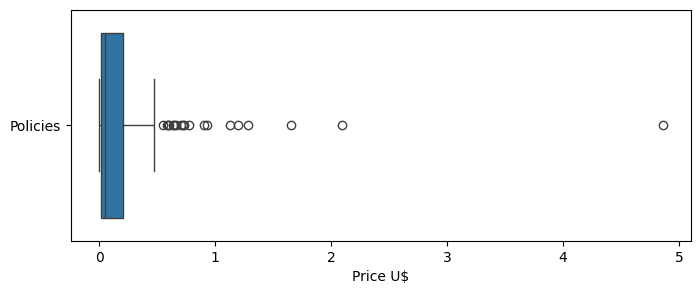

In [ ]:
# Visualizing descriptive stats and boxplot chart regarding the costs.

import seaborn as sns
import matplotlib.pyplot as plt

new_df = pd.DataFrame(pd.concat([texts['cost1'], texts['cost2'], texts['cost3']], axis=0, ignore_index=True), columns=['Policies'])
new_df = new_df[new_df['Policies'] != 0]

plt.figure(figsize=(8,3))
sns.boxplot(new_df, orient='h', )
plt.xlabel('Price U$')
plt.savefig('price per doc distr.png')
new_df.describe()

> Dropping huge files, costing more than U$1 to process, for bulk testing.

Gonna use texts2 for this.

In [ ]:
texts[(texts['cost1']>1) | (texts['cost2']>1) | (texts['cost3']>1)]

Bank  \
24                       DekaBank   
29                          E.Sun   
67                         PKO BP   
70  Raiffeisen Bank International   
83             Standard Chartered   
89     United Overseas Bank (UOB)   

                                                File1  \
24  Titel Untertitel Deka Group Sustainability Rep...   
29  About E.SUN Investors Corporate Governance Sus...   
67  Question 1. Policy for financing of the carbon...   
70  Focus on renewable energy, phase-out of therma...   
83  Annual Report 2023 [[Connecting the world’s mo...   
89  Introduction The energy sector plays an import...   

                                                File2  \
24                                                NaN   
29  9 E.SUN team of professionals Create a bright ...   
67  The PKO Bank Polski SA Group Directors’ Report...   
70  SUSTAINABILITY REPORT 2019 FOCUS ON SUSTAINABL...   
83                                                NaN   
89  Introduction While the metals and mining indus...   

                                                File3  Expansion  length1  \
24                                                NaN          0   450030   
29                                                NaN          0     4482   
67  en.media.pkobp.pl PKOBank PKOBank PolskiGroup ...          0     8059   
70                                                NaN          0     2654   
83                                                NaN          3  1943827   
89  UOB Annual Report 2019 Balancing Growth with R...          0     9375   

      tokens1     cost1  length2    tokens2     cost2  length3    tokens3  \
24  112507.50  1.125075        0       0.00  0.000000        0       0.00   
29    1120.50  0.011205   478764  119691.00  1.196910        0       0.00   
67    2014.75  0.020147   661232  165308.00  1.653080     9061    2265.25   
70     663.50  0.006635   514594  128648.50  1.286485        0       0.00   
83  485956.75  4.859567        0       0.00  0.000000        0       0.00   
89    2343.75  0.023438     5869    1467.25  0.014672   836779  209194.75   

       cost3  
24  0.000000  
29  0.000000  
67  0.022652  
70  0.000000  
83  0.000000  
89  2.091947

In [ ]:
texts2 = texts.drop(texts[(texts['cost1']>1) | (texts['cost2']>1) | (texts['cost3']>1)].index).copy()

> Balancing non-zero expansion score banks to compose the bulk testing dataset.

* Non-zero Expansion: 25 banks (all)
* Zero expansion: 25 banks (out of 63)

In [ ]:
texts2.Expansion.value_counts()

Expansion
0     63
3      5
6      5
1      3
7      3
8      3
9      2
10     2
5      1
4      1
Name: count, dtype: int64

> id_tested_neg:

The first time I ran this code, I forgot to set the seed for the "sample()" function. So, to be consistent on the testing process, I've manually inserted the indexes of the selected 0-scored banks.

In [ ]:
id_tested_neg = [32, 51, 66, 55, 93, 36, 61, 44, 13, 87, 76, 81, 92, 79, 82, 21,  4, 62, 27, 37, 23,  9,  7, 54,  2]

In [ ]:
# zero_exp = texts2[texts2.Expansion==0].sample(25) #randomly selecting 25 zero-scored banks
zero_exp = texts2.loc[id_tested_neg] # saved the id's of the firstly selected banks on 'id_tested_neg', so I could compare results.
zero_exp

Bank  \
32                      FirstRand   
51                         Mizuho   
66                        Ping An   
55        National Bank of Canada   
93                          Woori   
36          Hanwha Life Insurance   
61                         NordLB   
44                   KB Financial   
13             Cathay United Bank   
87                            UBS   
76                     Scotiabank   
81            SpareBank 1 SR-Bank   
92                        Westpac   
79                    SMFG - SMBC   
82                  Standard Bank   
21                  Dai-ichi Life   
4                   Bank of China   
62                    Norinchukin   
27                            DNB   
37                         Helaba   
23                            DBS   
9          BMO (Bank of Montreal)   
7                        BayernLB   
54  National Australia Bank (NAB)   
2                             ANZ   

                                                File1  \
32  POLICY ON ENERGY AND FOSSIL FUELS FINANCING – ...   
51  May 17, 2022 Mizuho Financial Group, Inc. Stre...   
66  Ping An Group Ping An Bank on Coal Lending Sta...   
55  Report on Environmental, Social and Governance...   
93  보도자료 | 우리금융그룹 about:reader?url=ﬁle%3A%2F%2F%2F...   
36  press release Hanwha Group’s six financial com...   
61  Green Bond Framework NORD/LB June 2022 2  Gre...   
44  Enacted on October 19, 2021 Environmental and ...   
13  2 C H A P T E R Climate 2 .1 ▶ Low- Carb o n E...   
87  Our sustainability and climate risk policy fra...   
76  Scotiabank’s Statement on Financing Coal April...   
81  Sustainability in SpareBank 1 SR-Bank June 202...   
92  WESTPAC 2023 CLIMATE CHANGE POSITION STATEMENT...   
79  Strengthening Efforts against Climate Change M...   
82  Standard Bank Group Climate Policy March 2022 ...   
21                                                NaN   
4   简体中文 繁体中文 English 无障碍浏览 适老版 全球服务 机构网点 在线客服 服务热...   
62  news release home > news release > News releas...   
27  Sustainability in DNB ASA’s credit activities ...   
37  SUSTAINABILITY CRITERIA FOR LENDING ACTIVITIES...   
23  Login About ﱴ Media Careers  Listing Login ...   
9   BMO Financial Group Statement on Coal Lending ...   
7   Guiding Principles for Transformation 10 July ...   
54  ANNUALREVIEW 2021National Australia Bank Limit...   
2   CLIMATE CHANGE COMMITMENT Supporting our custo...   

                                                File2  \
32  POLICY ON ENERGY AND FOSSIL FUELS FINANCING 30...   
51  Press Releases Strengthening initiatives for a...   
66                                                NaN   
55                                                NaN   
93                                                NaN   
36                                                NaN   
61  NORD/LB Group Presentation November 2023 1 Age...   
44                                                NaN   
13                                                NaN   
87  Sustainability and climate risk policy framewo...   
76                                                NaN   
81                                                NaN   
92  Net-Zero 2030 Targets Our methodology and appr...   
79  HOME > Sustainability > Environment > Response...   
82                                                NaN   
21                                                NaN   
4                                                 NaN   
62                                                NaN   
27                                                NaN   
37                                                NaN   
23  DBS Bank Our Approach to Responsible Financing...   
9                                                 NaN   
7                                                 NaN   
54  Acknowledgement of Country NAB acknowledges Au...   
2   INFORMATION ABOUT ANZ’S ENERGY POLICY OVERVIEW...   

                                                File3  Expansion  length1  \
32                     

In [ ]:
texts2 = pd.concat([texts2[texts2.Expansion!=0].copy(), zero_exp])

In [ ]:
texts2.fillna('', inplace=True)

In [ ]:
texts2.Expansion.value_counts()

Expansion
0     25
3      5
6      5
1      3
7      3
8      3
9      2
10     2
5      1
4      1
Name: count, dtype: int64

Policies
count  74.000000
mean    0.128136
std     0.179529
min     0.000122
25%     0.015252
50%     0.051750
75%     0.151039
max     0.778440

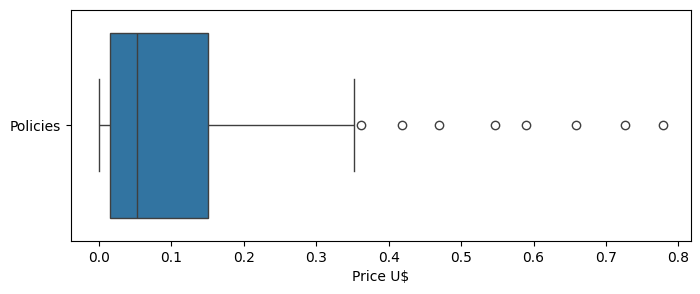

In [ ]:
# Visualizing the descriptives stats and boxplot regarding the costs post-processing.

import seaborn as sns
import matplotlib.pyplot as plt

new_df = pd.DataFrame(pd.concat([texts2['cost1'], texts2['cost2'], texts2['cost3']], axis=0, ignore_index=True), columns=['Policies'])
new_df = new_df[new_df['Policies'] != 0]

plt.figure(figsize=(8,3))
sns.boxplot(new_df, orient='h', )
plt.xlabel('Price U$')
plt.savefig('price per doc distr.png')
new_df.describe()

## Step 1 - Predicting Positive score

* Using `scores` class variable (approach 1)
* Merging all files in one for each bank before sending to gpt4.

In [ ]:
OPENAI_KEY = 'KEY_TO_OPENAI_API' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<------------------------------------- ADD KEY HERE

In [ ]:
# !pip install openai

In [ ]:
#importing OpenAI API Client
import openai

OPENAI_CLIENT = openai.OpenAI(api_key=OPENAI_KEY)

Creating a system_prompt based on the classes in "scores"

In [ ]:
scores.Description.values

array([' Exclusion of coal mine/plant/infrastructure developers (score 9)',
       ' Exclusion of coal mine/plant developers (score 8)',
       ' Exclusion of some thermal coal developers, with large uncertainty on the exact definition (score 3)',
       ' Exclusion of companies with thermal coal mines, plants and infrastructure expansion plans (score 9)',
       ' Exclusion of companies planning to expand their coal mining and unabated coal power operations, but only for new clients (score 1)',
       ' Exclusion of some coal developers, but only at the client level, not at the group level (score 3)',
       ' Exclusion of coal mine/plant/infrastructure developers and companies buying coal assets since the end of 2021 (score 9)',
       ' Exclusion of thermal coal mines and coal plant developers (score 8)',
       ' Exclusion of some coal mine/plant/infrastructure developers, but no precise definition of such developers (score 3)',
       ' Exclusion of coal plant developers (score 7)

> 2 Aproaches were tested here:

1. Passing the classes directly into the system_prompt of gpt4-turbo.
2. Using a function structure of the API.

As the expected output of the model is the index of the class that best fits to the bank policy, in approach 1 I've asked for an output in the format `index = X`. However, sometimes gpt4-turbo just ignores it and tries to add more text on the answer. In this case, I've asked it to classify again. For this reason, the temperature should not be 0 in this approach, or else it will be stuck in a loop.

The approach 2 would solve this problem. In this case, the system_prompt is a bit simpler, and the `function` structure obligates gpt4 tor answer in a specific way.

However, the use of the function is a bit weird: sometimes it just allucinates and answer something else.. I'm still trying to figure out why... So, I'll use approach 1 and keep approach 2 commented for now.

In [ ]:
# # Approach 2

# system_prompt = """You will act as a single-output text classifier.
# You will be provided with a text, representing the Expansion coal financy policy of a bank (coal mine/plant/infrasctructure).
# Based on the analysis of this text, you need to classify the expansion policy, choosing the best class between the options.
# """

########################################################################

# Approach 1

system_prompt = """You will act as a text classifier.
You will be provided with a text, representing the Expansion coal financy policy of a bank (coal mine/plant/infrasctructure).
Based on the analysis of this text, you need to classify the bank policy regarding the exclusion of financial services to companies planning new thermal coal mines, coal plants or coal infrastructure projects, choosing the best class between the following options:

1. Exclusion of coal mine/plant/infrastructure developers.
2. Exclusion of coal mine/plant developers.
3. Exclusion of some thermal coal developers, with large uncertainty on the exact definition.
4. Exclusion of companies with thermal coal mines, plants, and infrastructure expansion plans.
5. Exclusion of companies planning to expand their coal mining and unabated coal power operations, but only for new clients.
6. Exclusion of some coal developers, but only at the client level, not at the group level.
7. Exclusion of coal mine/plant/infrastructure developers and companies buying coal assets since the end of 2021.
8. Exclusion of thermal coal mines and coal plant developers.
9. Exclusion of some coal mine/plant/infrastructure developers, but no precise definition of such developers.
10. Exclusion of coal plant developers.
11. Exclusion of coal mine/plant/infrastructure developers and companies buying coal assets without a commitment to close them, and companies selling equipment for new coal projects.
12. Exclusion of companies with thermal coal mining and coal power expansion plans.
13. Exclusion of coal mine developers and power companies planning new coal plants.
14. Exclusion, from 2023, of some coal mine/plant developers, with some exceptions and only for utilities.
15. Exclusion of coal mine/plant developers but only at the client level, not at the group level, and only for some developers, not all.
16. Exclusion of all coal power developers.
17. Exclusion of mining and power companies increasing their coal capacity.
18. Exclusion of all companies developing new coal mining and/or coal power projects.
19. Exclusion of coal plant/mine/infrastructure developers and companies buying coal assets.
20. Exclusion of coal mine/plant/infrastructure developers but only for new clients.
21. Exclusion of coal plant developers but only for new clients.
22. Exclusion of all coal mine and coal plant developers since the end of 2021.
23. Exclusion of coal plant/mine/infrastructure developers, or companies buying coal assets.
24. No commitment regarding this criterion.
25. No thermal coal policy.

Your answer must be only the index of the best class, written exactly as: 'index = X', where X is the index of the class.

"""



> Single bank positive score evaluation...

In [ ]:
# Ideal bank policy example
external_string = [' We exclude fossil fuel companies involved with the extraction, production or generation of power from coal, oil or gas. For coal companies, we define this as any company which generates 5% or more of their revenue from coal, mines 10 Mt of coal per year or has coal power capacity of more than 5 Gw. Excluding coal companies means that we do not provide them with any part of a syndicated loan or revolving line of credit, and we do not undewrite bonds for these companies (or their subsidiaries). We require that companies (and their subsidiaries) which are currently involved in coal to an extent below the above defined thresholds, publish a plan to phase out coal by 2030 in Europe and OECD countries and 2040 worldwide. Importantly, this plan should be based on the closure, rather than sale, of coal assets, and should consider the social impacts of such closures. We also do not invest in any company which plans to build new coal assets, according to the Global Coal Exit List (https://www.coalexit.org/). Neither do we provide financing for the acquisition of coal mines, coal plants, and coal related infrastructure (including freight and import and export terminals). We exclude any company which produces or sells equipment for new coal projects. We do not facilitate coal asset sales.']

In [ ]:
# Name of the evaluated bank
tested_bank = 'Cathay United Bank'

In [ ]:

merged_contents = texts2[texts2.Bank==tested_bank].File1.values[0] +\
                  texts2[texts2.Bank==tested_bank].File2.values[0] +\
                  texts2[texts2.Bank==tested_bank].File3.values[0]

message = [{"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": merged_contents,
        },]

function = {
   "name": "predict_coal_policy_score",
   "description": "You will be provided with a text, representing the Expansion coal financy policy of a bank (coal mine/plant/infrasctructure). Based on the analysis of this text, you need to classify the expansion policy",
   "parameters": {
       "type": "object",
       "properties": {
           "prediction": {
               "type": "array",
               "items": {
                   "type": "string",
                   "enum": [
                        '1. Exclusion of coal mine/plant/infrastructure developers.',
                        '2. Exclusion of coal mine/plant developers.',
                        '3. Exclusion of some thermal coal developers, with large uncertainty on the exact definition.',
                        '4. Exclusion of companies with thermal coal mines, plants, and infrastructure expansion plans.',
                        '5. Exclusion of companies planning to expand their coal mining and unabated coal power operations, but only for new clients.',
                        '6. Exclusion of some coal developers, but only at the client level, not at the group level.',
                        '7. Exclusion of coal mine/plant/infrastructure developers and companies buying coal assets since the end of 2021.',
                        '8. Exclusion of thermal coal mines and coal plant developers.',
                        '9. Exclusion of some coal mine/plant/infrastructure developers, but no precise definition of such developers.',
                        '10. Exclusion of coal plant developers.',
                        '11. Exclusion of coal mine/plant/infrastructure developers and companies buying coal assets without a commitment to close them, and companies selling equipment for new coal projects.',
                        '12. Exclusion of companies with thermal coal mining and coal power expansion plans.',
                        '13. Exclusion of coal mine developers and power companies planning new coal plants.',
                        '14. Exclusion, from 2023, of some coal mine/plant developers, with some exceptions and only for utilities.',
                        '15. Exclusion of coal mine/plant developers but only at the client level, not at the group level, and only for some developers, not all.',
                        '16. Exclusion of all coal power developers.',
                        '17. Exclusion of mining and power companies increasing their coal capacity.',
                        '18. Exclusion of all companies developing new coal mining and/or coal power projects.',
                        '19. Exclusion of coal plant/mine/infrastructure developers and companies buying coal assets.',
                        '20. Exclusion of coal mine/plant/infrastructure developers but only for new clients.',
                        '21. Exclusion of coal plant developers but only for new clients.',
                        '22. Exclusion of all coal mine and coal plant developers since the end of 2021.',
                        '23. Exclusion of coal plant/mine/infrastructure developers, or companies buying coal assets.',
                        '24. No commitment regarding this criterion.',
                        '25. No thermal coal policy.'
                   ]
               },
               "description": "The predicted class of the bank's Expansion coal financy policy."
           }
       },
       "required": [
           "prediction"
       ]
   }
}



In [ ]:
res = OPENAI_CLIENT.chat.completions.create(
        model="gpt-4-turbo-preview",
        messages=message ,
        temperature=0.0,
        functions=[function],
        function_call={"name" : "predict_coal_policy_score"}
    )

res.choices[0] # full response object

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=FunctionCall(arguments='{"prediction":["24. No commitment regarding this criterion."]}', name='predict_coal_policy_score'), tool_calls=None))

In [ ]:
import json

json.loads(res.choices[0].message.function_call.arguments)["prediction"][0].split('.')[0] # extracted text response

'24'

In [ ]:
# Using the id to retrieve the predicted class

# id_score = int(res.choices[0].message.content.replace('index = ','')) #approach 1
id_score =  int(json.loads(res.choices[0].message.function_call.arguments)["prediction"][0].split('.')[0]) # approach 2 - function
bank_positive = scores.loc[id_score].Description
bank_positive

' No commitment regarding this criterion.'

In [ ]:
print(tested_bank)
print('Positive Score: ', scores.loc[id_score].Score)


Cathay United Bank
Positive Score:  0


> Bulk testing banks for positive scores

25 - zero scored banks

25 - non-zero scored banks (all of them)

In [ ]:
# Loop to check All banks

answers = []
for i in range(len(texts2)):
    print(f'Bank: {texts2.iloc[i].Bank}')

    # assamble the full-file, merging all available bank files
    input =  texts2.iloc[i].File1
    if not pd.isna(texts2.iloc[i].File2):
      input +=  texts2.iloc[i].File2
    if not pd.isna(texts2.iloc[i].File3):
      input +=  texts2.iloc[i].File3

    # if no file is found, the score is 0.
    if pd.isna(texts2.iloc[i].File1):
        print('index = 24') # 0 scores2 - 24 scores
        answers.append(24)

    else:
        message = [{"role": "system", "content": system_prompt},
            {
                "role": "user",
                "content": input,
            },]

        # the while is only needed without using function
        # but I kept it here so the code operates with both approaches
        res_len = 30
        count = 0
        while res_len > 20:  # 1 for function, otherwise 20
          res = OPENAI_CLIENT.chat.completions.create(
              model="gpt-4-turbo-preview", # 'gpt-4' "gpt-3.5-turbo" "gpt-4-turbo-preview"
              messages=message,
              # temperature=0.0,
              # functions=[function],
              # function_call={"name" : "predict_coal_policy_score"}
          )
          # print(json.loads(res.choices[0].message.function_call.arguments)["prediction"])
          # res_len = len(json.loads(res.choices[0].message.function_call.arguments)["prediction"])
          # count+=1
          # if count==5: res_len=1
          print(res.choices[0].message.content)
          res_len = len(res.choices[0].message.content)
        # answers.append(int(json.loads(res.choices[0].message.function_call.arguments)["prediction"][0].split('.')[0]))
        answers.append(int(res.choices[0].message.content.replace("Index = ","").replace("index = ","")))

    print(answers)
    print('=========================\n')

Bank: ABN Amro
index = 24
[24]

Bank: Barclays
index = 4
[24, 4]

Bank: BNP Paribas
index = 4
[24, 4, 4]

Bank: BPCE - Natixis
index = 4
[24, 4, 4, 4]

Bank: Citi
index = 4
[24, 4, 4, 4, 4]

Bank: Commerzbank
index = 4
[24, 4, 4, 4, 4, 4]

Bank: Credit Agricole
index = 4
[24, 4, 4, 4, 4, 4, 4]

Bank: Credit Mutuel
index = 4
[24, 4, 4, 4, 4, 4, 4, 4]

Bank: Danske Bank
index = 4
[24, 4, 4, 4, 4, 4, 4, 4, 4]

Bank: Desjardins
index = 1
[24, 4, 4, 4, 4, 4, 4, 4, 4, 1]

Bank: Erste
index = 4
[24, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4]

Bank: Handelsbanken
index = 24
[24, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 24]

Bank: HSBC
index = 12
[24, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 24, 12]

Bank: Intesa Sanpaolo
index = 4
[24, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 24, 12, 4]

Bank: Itau Unibanco
index = 4
[24, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 24, 12, 4, 4]

Bank: KBC
index = 4
[24, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 24, 12, 4, 4, 4]

Bank: La Banque postale
index = 1
[24, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 24, 12, 4, 4, 4, 1]

Bank: LBBW
i

> Saving the results....

In [ ]:
texts2['gpt_4_positive_scores_id'] = answers

In [ ]:
texts2['gpt_4_positive_scores'] = [ scores.loc[id].Score for id in answers ]
texts2.head()

Bank                                              File1  \
0         ABN Amro  Summary Sustainability Requirements Summary - ...   
6         Barclays  Climate Change Statement February 2023 1 Conte...   
10     BNP Paribas  BNP Paribas is accelerating its timeframe for ...   
11  BPCE - Natixis  October 27th, 2020 CSR sector policy applicabl...   
16            Citi  Environmental and Social Policy Framework Marc...   

                                                File2  \
0   Summary Sustainability Requirements Summary – ...   
6   Barclays’ Climate Strategy, Targets and Progre...   
10  CORPORATE SOCIAL RESPONSIBILITY .................   
11                                                      
16  Taskforce on Climate-Related Financial Disclos...   

                                                File3  Expansion  length1  \
0                                                              3    17407   
6   Climate and sustainability report The Climate ...          3    20719   
10                                                             6     4486   
11                                                             5    20681   
16                                                             1    82213   

     tokens1     cost1  length2   tokens2     cost2  length3   tokens3  \
0    4351.75  0.043518    17575   4393.75  0.043937        0      0.00   
6    5179.75  0.051798    88507  22126.75  0.221268   290383  72595.75   
10   1121.50  0.011215     2029    507.25  0.005072        0      0.00   
11   5170.25  0.051703        0      0.00  0.000000        0      0.00   
16  20553.25  0.205532   187903  46975.75  0.469757        0      0.00   

       cost3  gpt_4_positive_scores_id  gpt_4_positive_scores  
0   0.000000                        24                      0  
6   0.725957                         4                      9  
10  0.000000                         4                      9  
11  0.000000                         4                      9  
16  0.000000                         4                      9

In [ ]:
texts2.to_csv('coal_texts2_bulk_testing_full.csv')

In [ ]:
texts2_scores_only = texts2[['Bank', 'Expansion', 'gpt_4_positive_scores']].copy()

In [ ]:
texts2_scores_only.to_csv('coal_texts2_bulk_testing_scores_only.csv')

## Step 3 - Penalties

The approach here is similar to the one applied on scores, with a significant change: it is a multiclass classifier problem. In other words, each bank can have 1 to 3 penalty classes as output.

Using the table provided by CPT as negative justifications (penalties2) achieved better results, so I'll keep with it.

In [ ]:
penalties2

Description  Penalty
1   policy not applied to all assets / all financi...       -1
2   the policy does not apply to all the lines of ...       -1
3   more than a year after coming into effect, con...       -2
4   the restrictions do not apply to reinsurance t...       -1
5   the exclusion does not cover financing subsidi...       -2
6                                with some exceptions       -1
7   with large exceptions (e.g., geographical exce...       -2
8                        green bonds are not excluded       -1
9   the threshold for coal power developers is 300...       -1
10  it only applies to utilities and not to compan...       -1
11                                 None of the above.        0

> Use function as well?

For the penalties, I also tried to use the openai "`function`" feature. However, apparently the `"maxItems": 3` config is ignored.

Thus, gpt4 frequently answer with all the classes. Still trying to figure out why, so I'll use the approach 1 here: passing the classes directly into the system_prompt.

In either way, besides the bank policy, I pass the generated positive class of the bank (`bank_positive`) to provide gp4 with more context.

> Single bank negative scores evaluation

In [ ]:
bank_positive = scores.loc[texts2[texts2.Bank==tested_bank].gpt_4_positive_scores_id].Description.values[0]
bank_positive

' Exclusion of companies with thermal coal mining and coal power expansion plans (score 8)'

In [ ]:
# Approach 1

system_prompt = f"""
You will be provided with a text, representing the Expansion coal financy policy of a bank (coal mine/plant/infrasctructure).
The bank's policy contains the {bank_positive}.
To choose which classes are the best, asnwer to the following question: <<Despite the bank's policy, should his score be penalized for some reason?>>, where zero, one or more of the classes can fit in <<...>>
Based on the analysis of this text, you need to classify the negative aspects of the expansion policy, choosing the best between the following options:

1. policy not applied to all assets / all financial services.
2. the policy does not apply to all the lines of business [Property & Casualty, Engineering Lines (Construction All Risk – CAR), and Surety bonds] of/all risks covered by the re/insurer.
3. more than a year after coming into effect, contract renewals are still authorized by the policy.
4. the restrictions do not apply to reinsurance treaties.
5. the exclusion does not cover financing subsidiaries and/or when financing to the parent company remains possible.
6. with some exceptions
7. with large exceptions (e.g., geographical exceptions, financing allowed for vaguely-defined companies, etc.).
8. green bonds are not excluded
9. the threshold for coal power developers is 300MW (and not 100 MW)
10. it only applies to utilities and not to companies planning coal captive projects for specific industrial uses (i.e., steel, chemicals, etc.).
11. The bank should not be penalized.

If none of the classes have a definitive fit, the answer must be:

12. None of the above.

Your answer must be only the indexes of the best classes, written exactly as: 'indexes = X Y Z', 'indexes = X Y' or 'indexes = X', where X Y Z are the indexes of the classes.

The answer can vary from one to three classes.
"""

#################################################################################################

# # Approach 2 - Function

# system_prompt = f"""
#     You are a text classifier. Please return a maximum of 3 classes. Do not return more than 3 classes under any circumstances.
#     You will be provided with a text, representing the Expansion coal financy policy of a bank (coal mine/plant/infrasctructure).
#     The bank's policy contains the {positive}.
#     To choose which classes are the best, asnwer to the following question: <<Despite the bank's policy, should his score be penalized for some reason?>>, where zero, one or more of the classes can fit in <<...>>
#     Based on the analysis of this text, you need to classify the negative aspects of the expansion policy, choosing a maximum of 3 of the best between the options.

#     The answer must have a maximum of 3 classes!

#     The generated list must be sorted, from the most relevant class to the less relevant one.
#     """



In [ ]:
# Ideal policy text
external_string

[' We exclude fossil fuel companies involved with the extraction, production or generation of power from coal, oil or gas. For coal companies, we define this as any company which generates 5% or more of their revenue from coal, mines 10 Mt of coal per year or has coal power capacity of more than 5 Gw. Excluding coal companies means that we do not provide them with any part of a syndicated loan or revolving line of credit, and we do not undewrite bonds for these companies (or their subsidiaries). We require that companies (and their subsidiaries) which are currently involved in coal to an extent below the above defined thresholds, publish a plan to phase out coal by 2030 in Europe and OECD countries and 2040 worldwide. Importantly, this plan should be based on the closure, rather than sale, of coal assets, and should consider the social impacts of such closures. We also do not invest in any company which plans to build new coal assets, according to the Global Coal Exit List (https://www

In [ ]:
merged_contents = texts2[texts2.Bank==tested_bank].File1.values[0] +\
                  texts2[texts2.Bank==tested_bank].File2.values[0] +\
                  texts2[texts2.Bank==tested_bank].File3.values[0]

message = [{"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": merged_contents,
            # "content": external_string[0],

        },]

function2 = {
   "name": "predict_coal_policy_negative_scores",
   "description": "You will be provided with a text, representing the Expansion coal financy policy of a bank (coal mine/plant/infrasctructure). Based on the analysis of this text, you need to classify the expansion policy",
   "parameters": {
       "type": "object",
       "properties": {
           "prediction": {
               "type": "array",
               "maxItems": 3,
               "items": {
                   "type": "string",
                   "enum": [
                            '1. policy not applied to all assets / all financial services.',
                            '2. the policy does not apply to all the lines of business [Property & Casualty, Engineering Lines (Construction All Risk – CAR), and Surety bonds] of/all risks covered by the re/insurer.',
                            '3. more than a year after coming into effect, contract renewals are still authorized by the policy.',
                            '4. the restrictions do not apply to reinsurance treaties.',
                            '5. the exclusion does not cover financing subsidiaries and/or when financing to the parent company remains possible.',
                           ' 6. with some exceptions',
                            '7. with large exceptions (e.g., geographical exceptions, financing allowed for vaguely-defined companies, etc.).',
                            '8. green bonds are not excluded',
                            '9. the threshold for coal power developers is 300MW (and not 100 MW)',
                            '10. it only applies to utilities and not to companies planning coal captive projects for specific industrial uses (i.e., steel, chemicals, etc.).',
                            '11. None of the above.'
                   ]
               },
               "description": "The predicted class or classes (maximum of three) regarding the negative aspects of the bank's Expansion coal financy policy."
           }
       },
       "required": [
           "prediction"
       ]
   }
}

res = OPENAI_CLIENT.chat.completions.create(
        model="gpt-4-turbo-preview",  # 'gpt-4' "gpt-3.5-turbo"
        messages=message,
        temperature=0.0,
        # functions=[function2],
        # function_call={"name": "predict_coal_policy_negative_scores"},
    )

print(res.choices[0].message.content)
# print(json.loads(res.choices[0].message.function_call.arguments)["prediction"])

indexes = 7


In [ ]:
# # organizing the predicted classes in a list - approach 2
# [int(i.split('.')[0]) for i in json.loads(res.choices[0].message.function_call.arguments)["prediction"]]

In [ ]:
penalties2

Description  Penalty
1   policy not applied to all assets / all financi...       -1
2   the policy does not apply to all the lines of ...       -1
3   more than a year after coming into effect, con...       -2
4   the restrictions do not apply to reinsurance t...       -1
5   the exclusion does not cover financing subsidi...       -2
6                                with some exceptions       -1
7   with large exceptions (e.g., geographical exce...       -2
8                        green bonds are not excluded       -1
9   the threshold for coal power developers is 300...       -1
10  it only applies to utilities and not to compan...       -1
11                                 None of the above.        0

In [ ]:
# print(tested_bank)
# print('Score: ', scores2.loc[id_score].Score)
# print('Penalty:', penalties2.loc[[7]].Penalty)

# print('\nFinal Score: ', scores2.loc[id_score].Score+penalties2.loc[6].Penalty)

> Bulk testing for negative scores

As the system prompt for the penalties includes the score class of the bank, it will be individual for each bank. This is the reason why I've put it inside a function.

In [ ]:
def penalty_prompt(positive):
    # Approach 1

    system_prompt = f"""
    You will be provided with a text, representing the Expansion coal financy policy of a bank (coal mine/plant/infrasctructure).
    The bank's policy contains the {bank_positive}.
    To choose which classes are the best, asnwer to the following question: <<Despite the bank's policy, should his score be penalized for some reason?>>, where zero, one or more of the classes can fit in <<...>>
    Based on the analysis of this text, you need to classify the negative aspects of the expansion policy, choosing the best between the following options:

    1. policy not applied to all assets / all financial services.
    2. the policy does not apply to all the lines of business [Property & Casualty, Engineering Lines (Construction All Risk – CAR), and Surety bonds] of/all risks covered by the re/insurer.
    3. more than a year after coming into effect, contract renewals are still authorized by the policy.
    4. the restrictions do not apply to reinsurance treaties.
    5. the exclusion does not cover financing subsidiaries and/or when financing to the parent company remains possible.
    6. with some exceptions
    7. with large exceptions (e.g., geographical exceptions, financing allowed for vaguely-defined companies, etc.).
    8. green bonds are not excluded
    9. the threshold for coal power developers is 300MW (and not 100 MW)
    10. it only applies to utilities and not to companies planning coal captive projects for specific industrial uses (i.e., steel, chemicals, etc.).
    11. The bank should not be penalized.

    If none of the classes have a definitive fit, the answer must be:

    12. None of the above.

    Your answer must be only the indexes of the best classes, written exactly as: 'indexes = X Y Z', 'indexes = X Y' or 'indexes = X', where X Y Z are the indexes of the classes.

    The answer can vary from one to three classes.
    """

    # # Approach 2 - Function
    # system_prompt = f"""
    # You are a text classifier. Please return a maximum of 3 classes. Do not return more than 3 classes under any circumstances.
    # You will be provided with a text, representing the Expansion coal financy policy of a bank (coal mine/plant/infrasctructure).
    # The bank's policy contains the {positive}.
    # To choose which classes are the best, asnwer to the following question: <<Despite the bank's policy, should his score be penalized for some reason?>>, where zero, one or more of the classes can fit in <<...>>
    # Based on the analysis of this text, you need to classify the negative aspects of the expansion policy, choosing a maximum of 3 of the best between the options.

    # The answer must have a maximum of 3 classes!

    # The generated list must be sorted, from the most relevant class to the less relevant one.
    # """
    return system_prompt




In [ ]:
# Loop to check All banks

neg_answers = []
for i in range(len(texts2)):
    print(f'Bank: {texts2.iloc[i].Bank}')

    # No File = score 0 = no penalties
    if pd.isna(texts2.iloc[i].File1):
      print('index = 11')
      neg_answers.append(11)

    # If score = 0 , penalties are not needed
    elif texts2.iloc[i].gpt_4_positive_scores<=1:
      print('index = 11')
      neg_answers.append(11)

    else:
        input = texts2.iloc[i].File1 + texts2.iloc[i].File2 + texts2.iloc[i].File3
        bank_positive_side = scores.loc[texts2[texts2.Bank==texts2.iloc[i].Bank].gpt_4_positive_scores_id].Description.values[0]
        message = [{"role": "system", "content": penalty_prompt(bank_positive_side)},
            {
                "role": "user",
                "content": input,
            },]

        # The code to implement the function is commented
        res_len = 30
        while res_len > 20:
          res = OPENAI_CLIENT.chat.completions.create(
              model="gpt-4-turbo-preview",
              messages=message,
              # temperature=0.0,
              # functions=[function2],
              # function_call={"name": "predict_coal_policy_negative_scores"},
          )
          print(res.choices[0].message.content)
          res_len = len(res.choices[0].message.content)
          # print(json.loads(res.choices[0].message.function_call.arguments)["prediction"])
          # res_len = len([int(i.split('.')[0]) for i in json.loads(res.choices[0].message.function_call.arguments)["prediction"]])

        neg_answers.append((res.choices[0].message.content.replace("Indexes = ","").replace("indexes = ","")))
        # neg_answers.append([int(i.split('.')[0]) for i in json.loads(res.choices[0].message.function_call.arguments)["prediction"]])

    print(neg_answers)
    print('=========================\n')

Bank: ABN Amro
index = 11
[11]

Bank: Barclays
indexes = 3 6 7
[11, '3 6 7']

Bank: BNP Paribas
indexes = 11
[11, '3 6 7', '11']

Bank: BPCE - Natixis
indexes = 9
[11, '3 6 7', '11', '9']

Bank: Citi
indexes = 6 7 9 11
[11, '3 6 7', '11', '9', '6 7 9 11']

Bank: Commerzbank
indexes = 5 6
[11, '3 6 7', '11', '9', '6 7 9 11', '5 6']

Bank: Credit Agricole
indexes = 1 5 6 9
[11, '3 6 7', '11', '9', '6 7 9 11', '5 6', '1 5 6 9']

Bank: Credit Mutuel
indexes = 11
[11, '3 6 7', '11', '9', '6 7 9 11', '5 6', '1 5 6 9', '11']

Bank: Danske Bank
indexes = 6
[11, '3 6 7', '11', '9', '6 7 9 11', '5 6', '1 5 6 9', '11', '6']

Bank: Desjardins
indexes = 6
[11, '3 6 7', '11', '9', '6 7 9 11', '5 6', '1 5 6 9', '11', '6', '6']

Bank: Erste
indexes = 5 6
[11, '3 6 7', '11', '9', '6 7 9 11', '5 6', '1 5 6 9', '11', '6', '6', '5 6']

Bank: Handelsbanken
index = 11
[11, '3 6 7', '11', '9', '6 7 9 11', '5 6', '1 5 6 9', '11', '6', '6', '5 6', 11]

Bank: HSBC
indexes = 7
[11, '3 6 7', '11', '9', '6 7 9 11'

> Some routines to format the answers

So it can be used as indexes on the `penalties2` dataframe to extract the description and negative scores.

In [ ]:
# Approach 1
list_neg_answers = []

for ans in neg_answers:
  if type(ans)==int:
    list_neg_answers.append([ans])
  else:
    list_neg_answers.append((ans.split(' ')))


    if len(list_neg_answers[-1])==1:
      list_neg_answers[-1] = [int(list_neg_answers[-1][0])]

    else:
      for i, id in enumerate(list_neg_answers[-1]):
        if id != '':
          list_neg_answers[-1][i] = int(id)
        else:
          list_neg_answers[-1].pop()
  if list_neg_answers[-1][0]==12:
    list_neg_answers[-1][0]=11

list_neg_answers

# # Approach 2 - function
# list_neg_answers = []

# for ans in neg_answers:

#     if type(ans)==int:
#       list_neg_answers.append([ans])
#     else:
#       list_neg_answers.append(ans)

# list_neg_answers

[[11],
 [3, 6, 7],
 [11],
 [9],
 [6, 7, 9, 11],
 [5, 6],
 [1, 5, 6, 9],
 [11],
 [6],
 [6],
 [5, 6],
 [11],
 [7],
 [3, 5],
 [11],
 [6, 7],
 [1, 6],
 [11],
 [11],
 [3],
 [11],
 [6],
 [9, 10],
 [8, 9],
 [6],
 [11],
 [3, 5, 6],
 [11],
 [11],
 [11],
 [11],
 [8, 11],
 [11],
 [11],
 [11],
 [3],
 [11],
 [11],
 [11],
 [11],
 [11],
 [11],
 [11],
 [11],
 [3],
 [5],
 [1, 5],
 [11],
 [11],
 [11]]

In [ ]:
penalties2

Description  Penalty
1   policy not applied to all assets / all financi...       -1
2   the policy does not apply to all the lines of ...       -1
3   more than a year after coming into effect, con...       -2
4   the restrictions do not apply to reinsurance t...       -1
5   the exclusion does not cover financing subsidi...       -2
6                                with some exceptions       -1
7   with large exceptions (e.g., geographical exce...       -2
8                        green bonds are not excluded       -1
9   the threshold for coal power developers is 300...       -1
10  it only applies to utilities and not to compan...       -1
11                                 None of the above.        0

In [ ]:
def calculate_negative_scores(list_neg_answers):
  resp = []
  for id in list_neg_answers:
    # print(id)
    if len(id)==1:
      resp.append(penalties2.loc[id[0]].Penalty)
      pass
    else:
      sum = 0
      for id2 in id:
        # print(id2)
        sum += penalties2.loc[id2].Penalty
      resp.append(sum)
  return resp

In [ ]:
list_neg_answers

[[11],
 [3, 6, 7],
 [11],
 [9],
 [6, 7, 9, 11],
 [5, 6],
 [1, 5, 6, 9],
 [11],
 [6],
 [6],
 [5, 6],
 [11],
 [7],
 [3, 5],
 [11],
 [6, 7],
 [1, 6],
 [11],
 [11],
 [3],
 [11],
 [6],
 [9, 10],
 [8, 9],
 [6],
 [11],
 [3, 5, 6],
 [11],
 [11],
 [11],
 [11],
 [8, 11],
 [11],
 [11],
 [11],
 [3],
 [11],
 [11],
 [11],
 [11],
 [11],
 [11],
 [11],
 [11],
 [3],
 [5],
 [1, 5],
 [11],
 [11],
 [11]]

> Storing the results...

In [ ]:
texts2['gpt_4_neg_scores_id'] = list_neg_answers
texts2['gpt_4_neg_scores'] = calculate_negative_scores(list_neg_answers)
texts2['gpt_4_final_score'] = texts2['gpt_4_positive_scores'] + texts2['gpt_4_neg_scores']
texts2['gpt_4_final_score'] = [ 0 if texts2['gpt_4_final_score'].iloc[i]<0 else texts2['gpt_4_final_score'].iloc[i] for i in range(len(texts2))]

texts2.head()



Bank                                              File1  \
0         ABN Amro  Summary Sustainability Requirements Summary - ...   
6         Barclays  Climate Change Statement February 2023 1 Conte...   
10     BNP Paribas  BNP Paribas is accelerating its timeframe for ...   
11  BPCE - Natixis  October 27th, 2020 CSR sector policy applicabl...   
16            Citi  Environmental and Social Policy Framework Marc...   

                                                File2  \
0   Summary Sustainability Requirements Summary – ...   
6   Barclays’ Climate Strategy, Targets and Progre...   
10  CORPORATE SOCIAL RESPONSIBILITY .................   
11                                                      
16  Taskforce on Climate-Related Financial Disclos...   

                                                File3  Expansion  length1  \
0                                                              3    17407   
6   Climate and sustainability report The Climate ...          3    20719   
10                                                             6     4486   
11                                                             5    20681   
16                                                             1    82213   

     tokens1     cost1  length2   tokens2     cost2  length3   tokens3  \
0    4351.75  0.043518    17575   4393.75  0.043937        0      0.00   
6    5179.75  0.051798    88507  22126.75  0.221268   290383  72595.75   
10   1121.50  0.011215     2029    507.25  0.005072        0      0.00   
11   5170.25  0.051703        0      0.00  0.000000        0      0.00   
16  20553.25  0.205532   187903  46975.75  0.469757        0      0.00   

       cost3  gpt_4_positive_scores_id  gpt_4_positive_scores  \
0   0.000000                        24                      0   
6   0.725957                         4                      9   
10  0.000000                         4                      9   
11  0.000000                         4                      9   
16  0.000000                         4                      9   

   gpt_4_neg_scores_id  gpt_4_neg_scores  gpt_4_final_score  
0                 [11]                 0                  0  
6            [3, 6, 7]                -5                  4  
10                [11]                 0                  9  
11                 [9]                -1                  8  
16       [6, 7, 9, 11]                -4                  5

In [ ]:
texts2.to_csv('coal_texts2_bulk_testing_full2.csv')

In [ ]:
texts2_scores_only = texts2[['Bank', 'Expansion', 'gpt_4_positive_scores', 'gpt_4_neg_scores', 'gpt_4_final_score']].copy()

In [ ]:
texts2_scores_only.to_csv('coal_texts2_bulk_testing_scores_only2.csv')

# Evaluating some results...

You can run the notebook from here on, after running the "Extracting positive and negative comments" section.

In [ ]:
import pandas as pd
texts2 = pd.read_csv('coal_texts2_bulk_testing_full2.csv', index_col=0)
texts2.head(2)

Bank                                              File1  \
0  ABN Amro  Summary Sustainability Requirements Summary - ...   
6  Barclays  Climate Change Statement February 2023 1 Conte...   

                                               File2  \
0  Summary Sustainability Requirements Summary – ...   
6  Barclays’ Climate Strategy, Targets and Progre...   

                                               File3  Expansion  length1  \
0                                                NaN          3    17407   
6  Climate and sustainability report The Climate ...          3    20719   

   tokens1     cost1  length2   tokens2     cost2  length3   tokens3  \
0  4351.75  0.043518    17575   4393.75  0.043937        0      0.00   
6  5179.75  0.051798    88507  22126.75  0.221268   290383  72595.75   

      cost3  gpt_4_positive_scores_id  gpt_4_positive_scores  \
0  0.000000                        24                      0   
6  0.725957                         4                      9   

  gpt_4_neg_scores_id  gpt_4_neg_scores  gpt_4_final_score  
0                [11]                 0                  0  
6           [3, 6, 7]                -5                  4

In [ ]:
texts2_scores_only = pd.read_csv('coal_texts2_bulk_testing_scores_only2.csv', index_col=0)
texts2_scores_only.head(3)

Bank  Expansion  gpt_4_positive_scores  gpt_4_neg_scores  \
0      ABN Amro          3                      0                 0   
6      Barclays          3                      9                -5   
10  BNP Paribas          6                      9                 0   

    gpt_4_final_score  
0                   0  
6                   4  
10                  9

In [ ]:
# Calculating the absolute error of the generated scores and the actual expansion scores

texts2_scores_only['error'] = abs(texts2_scores_only['Expansion'] - texts2_scores_only['gpt_4_final_score'])

In [ ]:
# Some descriptive statistics

texts2_scores_only.error.describe()

count    50.000000
mean      3.640000
std       3.211967
min       0.000000
25%       1.000000
50%       3.000000
75%       7.000000
max       9.000000
Name: error, dtype: float64

In [ ]:
# The mean square error

from sklearn.metrics import mean_squared_error

mean_squared_error(texts2_scores_only['Expansion'], texts2_scores_only['gpt_4_final_score'])

23.36

In [ ]:
# Sorting the texts2_scores_only by the errors

texts2_scores_only[texts2_scores_only.Expansion!=0].sort_values('error', ascending=False)

Bank  Expansion  gpt_4_positive_scores  gpt_4_neg_scores  \
88             UniCredit         10                      3                -1   
60                Nordea          8                      0                 0   
34         Handelsbanken          7                      0                 0   
86                    TD          1                      9                -2   
17           Commerzbank          1                      9                -3   
16                  Citi          1                      9                -4   
56               NatWest          3                      9                -2   
30                 Erste          3                      9                -3   
48  Lloyds Banking Group          6                      9                 0   
46     La Banque postale         10                      9                -2   
0               ABN Amro          3                      0                 0   
11        BPCE - Natixis          5                      9                -1   
10           BNP Paribas          6                      9                 0   
38                  HSBC          3                      8                -2   
45                   KBC          8                      9                -3   
22           Danske Bank          6                      9                -1   
47                  LBBW          7                      9                 0   
19       Credit Agricole          6                      9                -5   
25            Desjardins          9                      9                -1   
6               Barclays          3                      9                -5   
40       Intesa Sanpaolo          4                      9                -4   
42         Itau Unibanco          8                      9                 0   
65                    OP          7                      9                -1   
80      Societe Generale          6                      9                -2   
20         Credit Mutuel          9                      9                 0   

    gpt_4_final_score  error  
88                  2      8  
60                  0      8  
34                  0      7  
86                  7      6  
17                  6      5  
16                  5      4  
56                  7      4  
30                  6      3  
48                  9      3  
46                  7      3  
0                   0      3  
11                  8      3  
10                  9      3  
38                  6      3  
45                  6      2  
22                  8      2  
47                  9      2  
19                  4      2  
25                  8      1  
6                   4      1  
40                  5      1  
42                  9      1  
65                  8      1  
80                  7      1  
20                  9      0

In [ ]:
# Some descriptive statistics of the non-zero scoring banks

texts2_scores_only[texts2_scores_only.Expansion!=0]['error'].describe()

count    25.000000
mean      3.080000
std       2.215852
min       0.000000
25%       1.000000
50%       3.000000
75%       4.000000
max       8.000000
Name: error, dtype: float64

In [ ]:
# Some descriptive statistics of the zero scoring banks

texts2_scores_only[texts2_scores_only.Expansion==0]['error'].describe()

count    25.000000
mean      4.200000
std       3.937004
min       0.000000
25%       0.000000
50%       6.000000
75%       8.000000
max       9.000000
Name: error, dtype: float64

In [ ]:
# All info of the top 17 most inacurate answers. (absolute errors >= 2 )

texts2.loc[texts2_scores_only.sort_values(by='error', ascending=True).index[:17]]

Bank  \
2                             ANZ   
54  National Australia Bank (NAB)   
66                        Ping An   
55        National Bank of Canada   
87                            UBS   
81            SpareBank 1 SR-Bank   
20                  Credit Mutuel   
21                  Dai-ichi Life   
4                   Bank of China   
62                    Norinchukin   
27                            DNB   
7                        BayernLB   
25                     Desjardins   
80               Societe Generale   
40                Intesa Sanpaolo   
42                  Itau Unibanco   
6                        Barclays   

                                                File1  \
2   CLIMATE CHANGE COMMITMENT Supporting our custo...   
54  ANNUALREVIEW 2021National Australia Bank Limit...   
66  Ping An Group Ping An Bank on Coal Lending Sta...   
55  Report on Environmental, Social and Governance...   
87  Our sustainability and climate risk policy fra...   
81  Sustainability in SpareBank 1 SR-Bank June 202...   
20  FEBRUARY 20, 2020 PRESS RELEASE 2019 – A RECOR...   
21                                                NaN   
4   简体中文 繁体中文 English 无障碍浏览 适老版 全球服务 机构网点 在线客服 服务热...   
62  news release home > news release > News releas...   
27  Sustainability in DNB ASA’s credit activities ...   
7   Guiding Principles for Transformation 10 July ...   
25  Desjardins's Position on Coal Coal is the worl...   
80  July 2020 Public Document Thermal Coal sector ...   
40  RULES FOR LENDING OPERATIONS IN THE COAL SECTO...   
42  Itaú Unibanco Holding S.A. climate report_ Pre...   
6   Climate Change Statement February 2023 1 Conte...   

                                                File2  \
2   INFORMATION ABOUT ANZ’S ENERGY POLICY OVERVIEW...   
54  Acknowledgement of Country NAB acknowledges Au...   
66                                                NaN   
55                                                NaN   
87  Sustainability and climate risk policy framewo...   
81                                                NaN   
20  Sector policy – COAL SECTOR Introduction Crédi...   
21                                                NaN   
4                                                 NaN   
62                                                NaN   
27                                                NaN   
7                                                 NaN   
25                                                NaN   
80                                                NaN   
40                                                NaN   
42                                                NaN   
6   Barclays’ Climate Strategy, Targets and Progre...   

                                                File3  Expansion  length1  \
2   INFORMATION ABOUT ANZ’S EXTRACTIVES INDUSTRY P...          0    16553   
54                                                NaN          0   235729   
66                                                NaN          0     3477   
55                                                NaN          0   263674   
87                                                NaN          0    28661   
81                                                NaN          0    95159   
20                                                NaN          9    83993   
21                                                NaN          0        0   
4                                                 NaN          0     1369   
62                                                NaN          0      300   
27                                                NaN          0    15811   
7                                                 NaN          0   104081   
25                                                NaN          9     2401   
80                                                NaN          6    19795   
40                                                NaN          4     6460   
42                                                NaN          8   140628   

In [ ]:
# Standarizing the names, and adding an absolute and a regulare error

texts2_scores_only['abs_error'] = abs(texts2_scores_only['Expansion'] - texts2_scores_only['gpt_4_final_score'])
texts2_scores_only['error'] = (texts2_scores_only['Expansion'] - texts2_scores_only['gpt_4_final_score'])

In [ ]:
# Merging texts2_scores_only with cpt to get score and penalty values as well.

texts2_scores_only = pd.merge(texts2_scores_only, cpt[['Financial institutions', 'score', 'penalty']],
         left_on='Bank', right_on='Financial institutions')\
         .drop('Financial institutions', axis=1)

# Standarizing column names
texts2_scores_only.columns = ['Bank', 'Expansion', 'gpt_4_positive_scores', 'gpt_4_neg_scores',
       'gpt_4_final_score', 'abs_error', 'error', 'pos_score_cpt', 'neg_score_cpt']

# Adjusting the formats
texts2_scores_only = texts2_scores_only.fillna(0)

texts2_scores_only.pos_score_cpt = texts2_scores_only.pos_score_cpt.astype(int)
texts2_scores_only.neg_score_cpt = texts2_scores_only.neg_score_cpt.astype(int)

In [ ]:
texts2_scores_only.head(3)

Bank  Expansion  gpt_4_positive_scores  gpt_4_neg_scores  \
0     ABN Amro          3                      0                 0   
1     Barclays          3                      9                -5   
2  BNP Paribas          6                      9                 0   

   gpt_4_final_score  abs_error  error  pos_score_cpt  neg_score_cpt  
0                  0          3      3              3              0  
1                  4         -1      1              3              0  
2                  9         -3      3              9             -2

> Quality of positive and negative scores sepparatelly

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(texts2_scores_only['pos_score_cpt'], texts2_scores_only['gpt_4_positive_scores'])

30.86

In [ ]:
mean_squared_error(texts2_scores_only['neg_score_cpt'], texts2_scores_only['gpt_4_neg_scores'])

3.3

* The error is higher on the positive part of the prediction.
  * Why?
  * Which documents fared worse?
  * What are their characteristics?

In [ ]:
texts2_scores_only['pos_error'] = abs(texts2_scores_only['pos_score_cpt'] - texts2_scores_only['gpt_4_positive_scores'])
texts2_scores_only['neg_error'] = abs(texts2_scores_only['neg_score_cpt'] - texts2_scores_only['gpt_4_neg_scores'])

texts2_scores_only[['Bank', 'pos_score_cpt', 'gpt_4_positive_scores', 'pos_error']].sort_values('pos_error', ascending=False)[:13]

Bank  pos_score_cpt  gpt_4_positive_scores  pos_error
25               FirstRand              0                      9          9
35              Scotiabank              0                      9          9
46  BMO (Bank of Montreal)              0                      9          9
45                     DBS              0                      9          9
26                  Mizuho              0                      9          9
44                  Helaba              0                      9          9
39           Standard Bank              0                      9          9
38             SMFG - SMBC              0                      9          9
31                  NordLB              0                      9          9
32            KB Financial              0                      9          9
20                  Nordea              8                      0          8
33      Cathay United Bank              0                      8          8
23                      TD              1                      9          8

> Positive or negative errors?

In [ ]:
(texts2_scores_only.error<0).sum()

0

In [ ]:
(texts2_scores_only.error>0).sum()

38

In [ ]:
texts2_scores_only[texts2_scores_only.error<0]

Empty DataFrame
Columns: [Bank, Expansion, gpt_4_positive_scores, gpt_4_neg_scores, gpt_4_final_score, abs_error, error, pos_score_cpt, neg_score_cpt, pos_error, neg_error]
Index: []

> Correct scores

In [ ]:
(texts2_scores_only.error==0).sum()

12

> Saving the performance outcomes...

In [ ]:
texts2_scores_only.index = texts2.index
id_tested_neg = texts2_scores_only[texts2_scores_only.Expansion==0].index
texts2_scores_only.loc[id_tested_neg]

Bank  Expansion  gpt_4_positive_scores  \
32                      FirstRand          0                      9   
51                         Mizuho          0                      9   
66                        Ping An          0                      0   
55        National Bank of Canada          0                      0   
93                          Woori          0                      7   
36          Hanwha Life Insurance          0                      7   
61                         NordLB          0                      9   
44                   KB Financial          0                      9   
13             Cathay United Bank          0                      8   
87                            UBS          0                      0   
76                     Scotiabank          0                      9   
81            SpareBank 1 SR-Bank          0                      0   
92                        Westpac          0                      8   
79                    SMFG - SMBC          0                      9   
82                  Standard Bank          0                      9   
21                  Dai-ichi Life          0                      0   
4                   Bank of China          0                      0   
62                    Norinchukin          0                      0   
27                            DNB          0                      0   
37                         Helaba          0                      9   
23                            DBS          0                      9   
9          BMO (Bank of Montreal)          0                      9   
7                        BayernLB          0                      0   
54  National Australia Bank (NAB)          0                      0   
2                             ANZ          0                      0   

    gpt_4_neg_scores  gpt_4_final_score  abs_error  error  pos_score_cpt  \
32                 0                  9         -9      9              0   
51                -5                  4         -4      4              0   
66                 0                  0          0      0              0   
55                 0                  0          0      0              0   
93                 0                  7         -7      7              0   
36                 0                  7         -7      7              0   
61                -1                  8         -8      8              0   
44                 0                  9         -9      9              0   
13                 0                  8         -8      8              0   
87                 0                  0          0      0              0   
76                -2                  7         -7      7              0   
81                 0                  0          0      0              0   
92                 0                  8         -8      8              0   
79                 0                  9         -9      9              0   
82                 0                  9         -9      9              0   
21                 0                  0          0      0              0   
4                  0                  0          0      0              0   
62                 0                  0          0      0              0   
27                 0                  0          0      0              0   
37                -2                  7         -7      7              0   
23                -2                  7         -7      7              0   
9                 -3                  6         -6      6              0   
7                  0                  0          0      0              0   
54                 0                  0          0      0              0   
2                  0                  0          0      0              0   

    neg_score_cpt  pos_error  neg_error  
32              0          9          0  
51              0          9          5  
66              0          0          0  
55              0          0         

In [ ]:
texts2_scores_only.to_csv('gpt4-turbo-expansion-score-testing.csv')